### Project Overview

This project tackles the House Prices regression problem using a full end-to-end
machine learning pipeline.  
It covers exploratory data analysis, outlier and missing-value handling,
feature engineering, feature selection, and advanced ensemble modeling.

Multiple models were optimized using cross-validation and Optuna,
then combined into a weighted Voting Regressor to achieve robust
and stable performance.


In [1]:
# core libraries
import numpy as np
import pandas as pd
import os

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model evaluation matrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# model selection & validation
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# preprocessing & feature engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import category_encoders as ce

# pipelines & column transformers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# linear & regularized models
from sklearn.linear_model import LinearRegression, Ridge

# tree-based & ensemple models
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor

# boosting models (external libraries)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

# hyperparameter optimization
import optuna

### Data Loading

In [2]:
train_path = os.path.join(os.getcwd(), 'data', 'train.csv')
test_path = os.path.join(os.getcwd(), 'data', 'test.csv')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

### Exploratory Data Analysis (EDA)
This EDA focuses on understanding feature behavior, detecting anomalies,
and guiding data-driven preprocessing decisions.

### Data Cleaning

#### `Outlier Detection`
Scatter plots between numerical features and the target revealed
a small number of observations with inconsistent price behavior.
After careful inspection, 22 observations were removed.

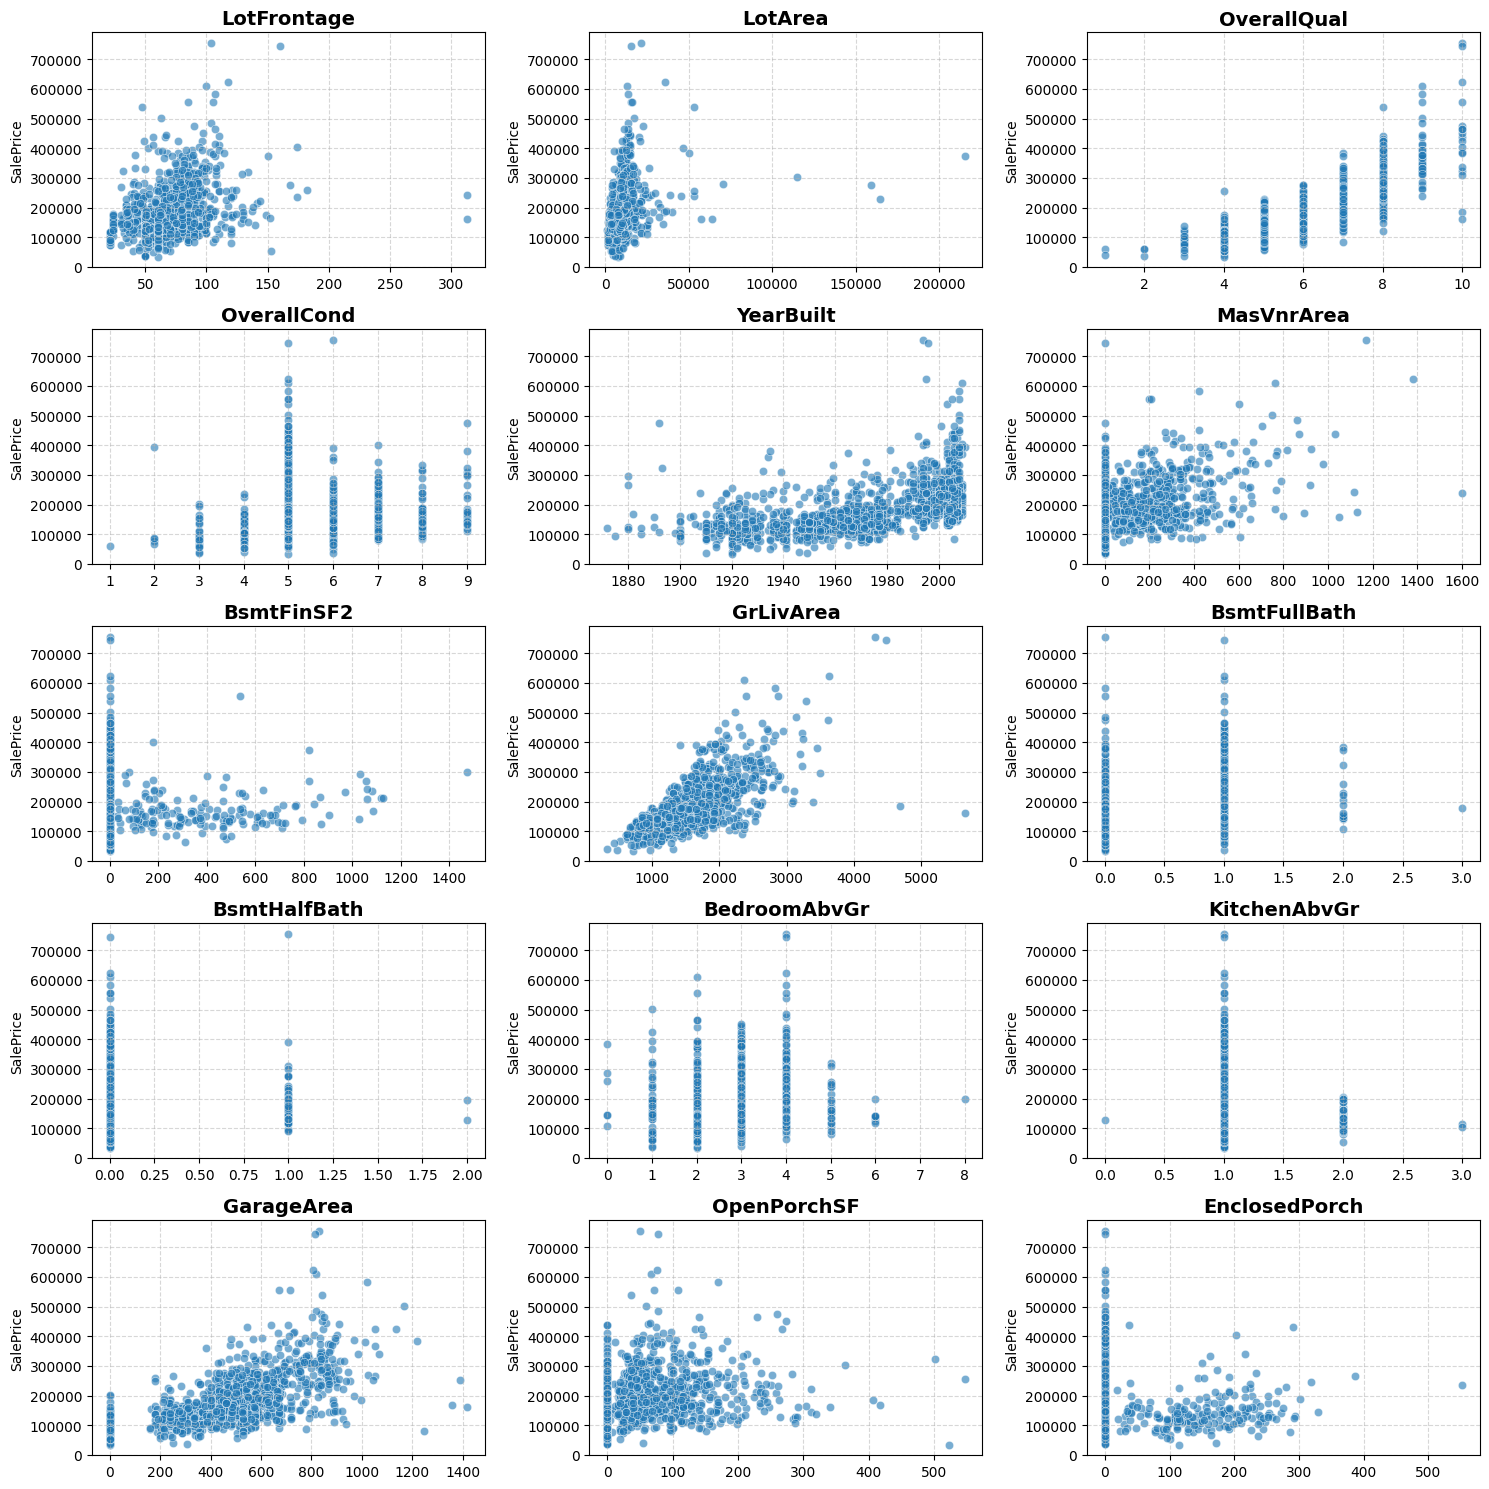

In [3]:
outlier_features = [
    'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
    'YearBuilt', 'MasVnrArea', 'BsmtFinSF2', 'GrLivArea', 
    'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
    'GarageArea', 'OpenPorchSF', 'EnclosedPorch'
]

fig, axes = plt.subplots(5, 3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(outlier_features):
    sns.scatterplot(x=col, y='SalePrice', data=train_df, ax=axes[i], alpha=0.6)
    axes[i].set_title(f'{col}', fontsize=14, fontweight='bold')
    axes[i].grid(True, linestyle='--', alpha=0.5)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [4]:
# Outliers were identified using scatter plots across multiple
# numeric features and removed only when inconsistent with price behavior

values = [935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 441, 524, 739, 598, 955, 636, 49, 810, 1062, 1191, 496, 198]

# outlier drop
train_df = train_df[~train_df.Id.isin(values)].reset_index(drop=True)

#### `Missing Values Strategy`
Missing values were handled based on feature meaning and data type.

In [5]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20)

,0
PoolQC,1434
MiscFeature,1387
Alley,1348
Fence,1162
MasVnrType,860
FireplaceQu,683
LotFrontage,255
GarageQual,76
GarageFinish,76
GarageType,76


In [6]:
no_cols = [
    'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 
    'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 
    'BsmtExposure', 'BsmtQual', 'BsmtCond'
]
for col in no_cols:
    train_df[col] = train_df[col].fillna('No')
    test_df[col] = test_df[col].fillna('No')

zero_cols = ['LotFrontage', 'MasVnrArea']
for col in zero_cols:
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)

unf_cols = ['BsmtFinType1', 'BsmtFinType2']
for col in unf_cols:
    train_df[col] = train_df[col].fillna('Unf')
    test_df[col] = test_df[col].fillna('Unf')
    
train_df['Electrical'] = train_df['Electrical'].fillna('SBrkr')
test_df['Electrical'] = test_df['Electrical'].fillna('SBrkr')

The following box plots show how missing-related categories affect SalePrice,
helping assess whether missing values carry meaningful price signals
or can be safely imputed.

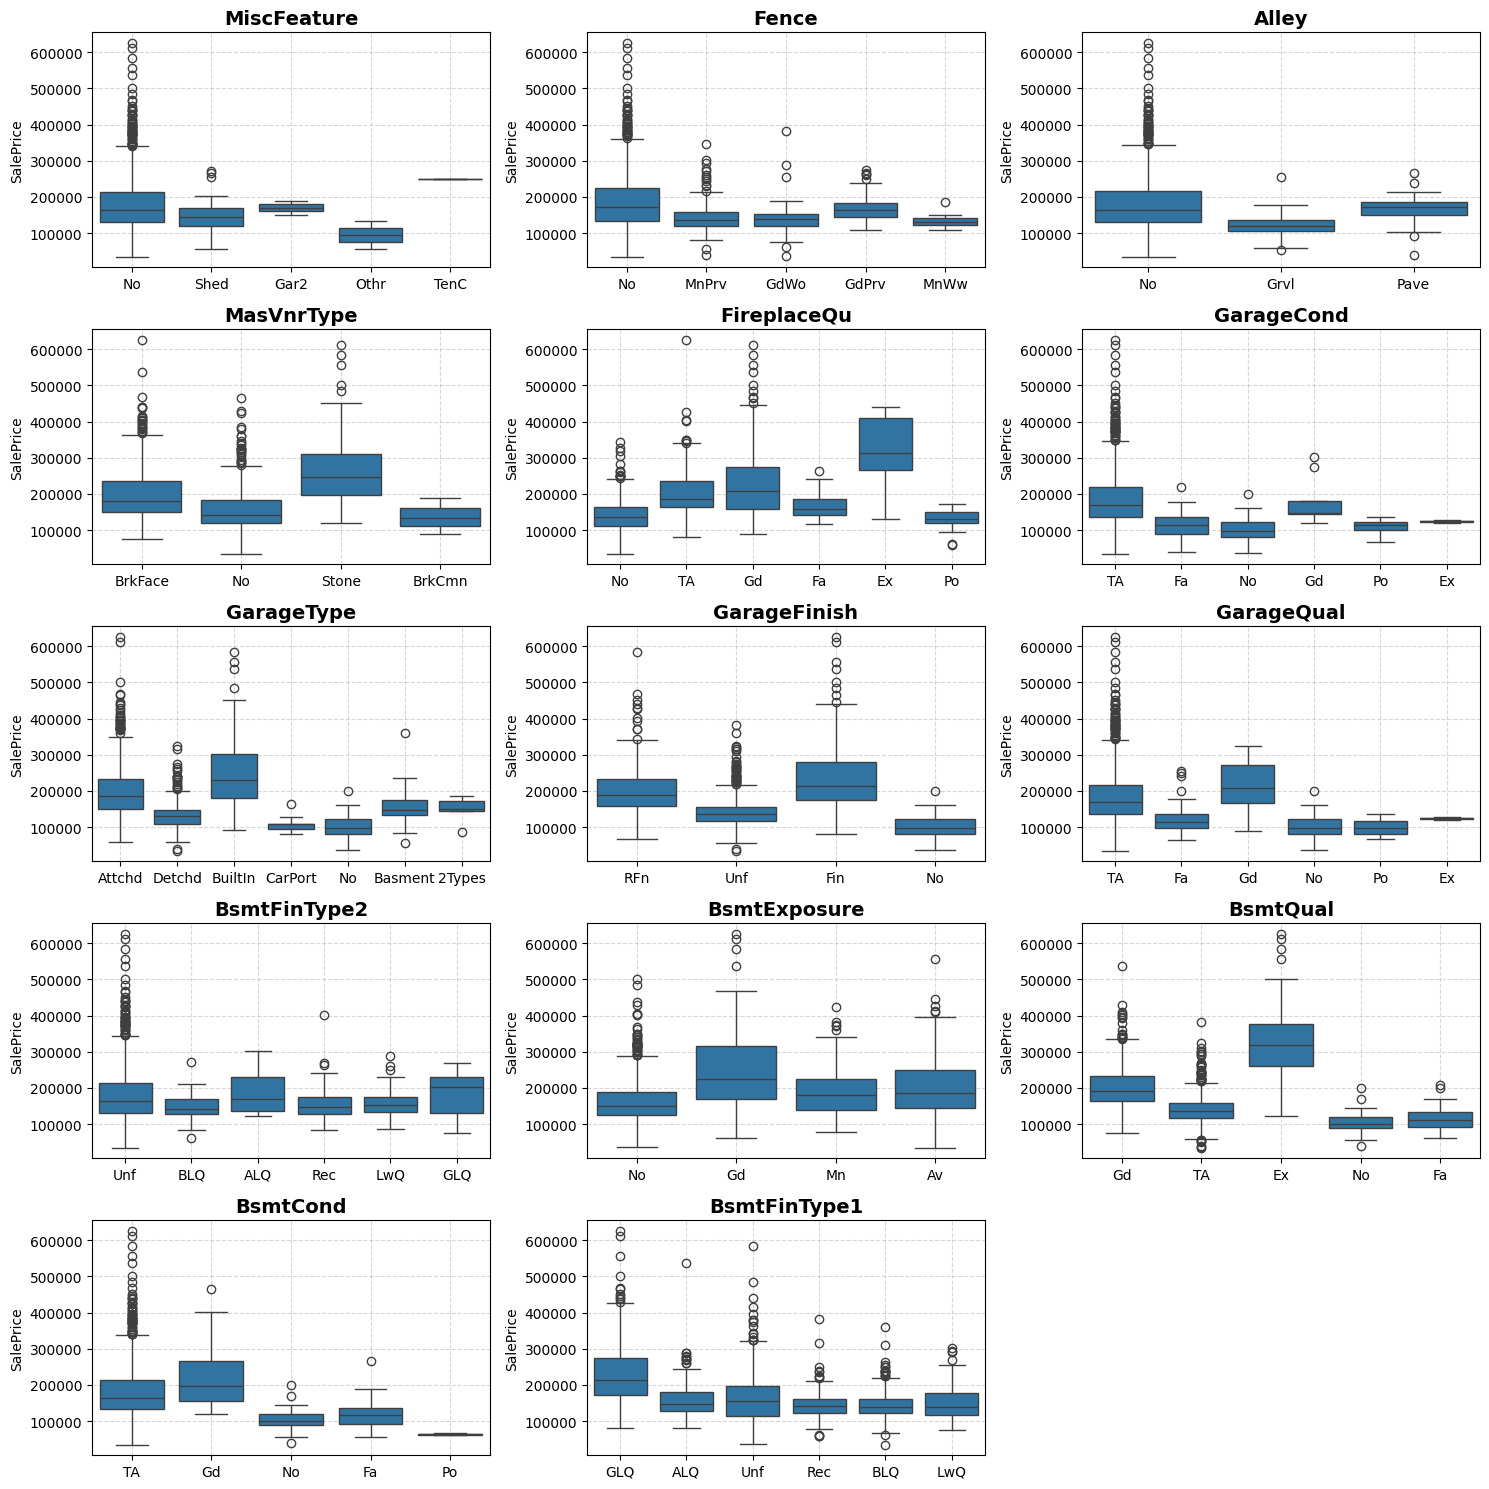

In [7]:
NaN_features = [
    'MiscFeature', 'Fence', 'Alley', 'MasVnrType', 
    'FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish', 
    'GarageQual', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 
    'BsmtCond', 'BsmtFinType1'
]

fig, axes = plt.subplots(5, 3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(NaN_features):
    sns.boxplot(x=col, y='SalePrice', data=train_df, ax=axes[i])
    axes[i].set_title(f'{col}', fontsize=14, fontweight='bold')
    axes[i].grid(True, linestyle='--', alpha=0.5)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Feature Engineering

#### `Target Transformation`
This distribution shows the original SalePrice target,
revealing strong right skewness that can bias regression models.

<Axes: xlabel='SalePrice', ylabel='Count'>

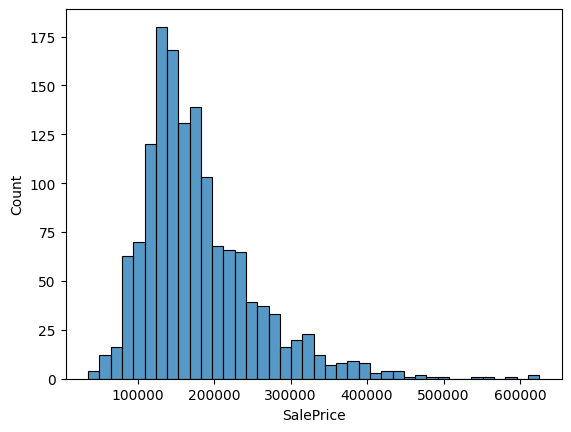

In [8]:
sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

In [9]:
# Reducing Target Skewness Using Log Transformation
train_df['SalePrice'] =  np.log1p(train_df['SalePrice'])

Log transformation reduces target skewness,
resulting in a more symmetric distribution suitable for linear models.


<Axes: xlabel='SalePrice', ylabel='Count'>

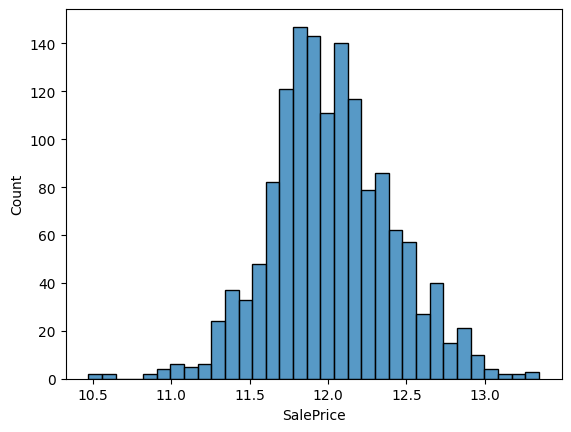

In [10]:
sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

#### `Ordinal & Nominal Encoding Strategy`

In [11]:
# Mapping for Ordinal features
all_mappings = {
    'Qual_map': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0, 'No': 0},
    
    'BsmtFinType_map': {'GLQ': 3, 'ALQ': 2, 'Unf': 2, 'BLQ': 1, 'Rec': 1, 'LwQ': 1, 'No': 0, 'NA': 0},
    'BsmtExposure_map': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'No_Bsmt': 0},
    'BsmtCond_map': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0, 'No': 0},
    
    'GarageFinish_map': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'No': 0},
    'GarageQual_map': {'Gd': 3, 'Ex': 2, 'TA': 2, 'Fa': 1, 'Po': 0, 'No': 0},
    'GarageCond_map': {'Gd': 2, 'TA': 2, 'Ex': 1, 'Fa': 1, 'Po': 1, 'No': 0},
    'GarageType_map': {'BuiltIn': 3, '2Types': 2, 'Basment': 2, 'Attchd': 2, 'Detchd': 1, 'CarPort': 0, 'No': 0},
    
    'LandSlope_map': {'Gtl': 0, 'Mod': 1, 'Sev': 0},
    'LandContour_map': {'HLS': 3, 'Low': 2, 'Lvl': 1, 'Bnk': 0},
    'LotShape_map': {'Reg': 0, 'IR1': 1, 'IR2': 1, 'IR3': 1},
    'MSZoning_map': {'FV': 2, 'RL': 1, 'C (all)': 0, 'RM': 0, 'RH': 0},
    
    'Foundation_map': {'PConc': 2, 'Wood': 2, 'Stone': 2, 'CBlock': 1, 'BrkTil': 1, 'Slab': 0},
    'Electrical_map': {'SBrkr': 1, 'FuseF': 0, 'FuseA': 0, 'FuseP': 0, 'Mix': 0},
    'HeatingQC_map': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 2, 'No': 0},
    'CentralAir_map': {'Y': 1, 'N': 0},
    
    'Functional_map': {'Typ': 3, 'Min1': 1, 'Min2': 1, 'Mod': 1, 'Maj1': 1, 'Maj2': 0, 'Sev': 1, 'Sal': 0},
    'HouseStyle_map': {'2Story': 2, '2.5Fin': 2, 'SLvl': 2, '1Story': 1, '1.5Fin': 1, 'SFoyer': 1, '2.5Unf': 1, '1.5Unf': 0},
    'MasVnrType_map': {'Stone': 2, 'BrkFace': 1, 'BrkCmn': 0, 'No': 0},
    'ExterCond_map': {'Ex': 3, 'TA': 3, 'Gd': 2, 'Fa': 1, 'Po': 1, 'No': 0},
    'PavedDrive_map': {'Y': 2, 'P': 1, 'N': 0},
    'Alley_map': {'Pave': 2, 'No': 1, 'Grvl': 0},
    'Condition1_map': {'PosA': 2, 'PosN': 2, 'RRNe': 1, 'RRNn': 1, 'Norm': 1, 'RRAe': 0, 'RRAn': 0, 'Feedr': 0, 'Artery': 0}
}

def apply_ordinal_mappings(df, maps):
    qual_cols = ['ExterQual', 'BsmtQual', 'KitchenQual', 'FireplaceQu']
    for col in qual_cols:
        df[col] = df[col].map(maps['Qual_map']).fillna(0)
        
    for col in ['BsmtFinType1', 'BsmtFinType2']:
        df[col] = df[col].map(maps['BsmtFinType_map']).fillna(0)
        
    single_mappings = {
        'HeatingQC': 'HeatingQC_map', 'BsmtExposure': 'BsmtExposure_map',
        'PavedDrive': 'PavedDrive_map', 'GarageFinish': 'GarageFinish_map',
        'CentralAir': 'CentralAir_map', 'LandSlope': 'LandSlope_map',
        'LandContour': 'LandContour_map', 'LotShape': 'LotShape_map',
        'Functional': 'Functional_map', 'Alley': 'Alley_map',
        'Foundation': 'Foundation_map', 'HouseStyle': 'HouseStyle_map',
        'MasVnrType': 'MasVnrType_map', 'GarageType': 'GarageType_map',
        'MSZoning': 'MSZoning_map', 'Condition1': 'Condition1_map',
        'ExterCond': 'ExterCond_map', 'GarageQual': 'GarageQual_map',
        'Electrical': 'Electrical_map', 'BsmtCond': 'BsmtCond_map',
        'GarageCond': 'GarageCond_map'
    }
    
    for col, map_name in single_mappings.items():
        df[col] = df[col].map(maps[map_name]).fillna(0)
        
    return df

train_df = apply_ordinal_mappings(train_df, all_mappings)
test_df = apply_ordinal_mappings(test_df, all_mappings)

In [12]:
# Mapping for Nominal features
mappings = {
    'Neighborhood': {k: 'Rare_N' for k in ['MeadowV', 'Blmngtn', 'BrDale', 'Veenker', 'NPkVill', 'Blueste']},
    'Exterior1st': {k: 'Rare_Ext' for k in ['AsbShng', 'BrkComm', 'Stone', 'AsphShn', 'ImStucc', 'CBlock']},
    'Exterior2nd': {k: 'Rare_Ext' for k in ['AsbShng', 'ImStucc', 'Brk Cmn', 'Stone', 'AsphShn', 'Other', 'CBlock']},
    'LotConfig': {'CulDSac': 'CulDSac_FR3', 'FR3': 'CulDSac_FR3'},
    'RoofStyle': {k: 'Other' for k in ['Gambrel', 'Flat', 'Mansard', 'Shed']}
}

for col, mapping in mappings.items():
    train_df[col] = train_df[col].replace(mapping)
    test_df[col] = test_df[col].replace(mapping)

def refine_sales(df):
    df['SaleCondition'] = df['SaleCondition'].apply(
        lambda x: 'Sale_Discount' if x in ['Abnorml', 'AdjLand']
        else 'Sale_High' if x == 'Partial'
        else 'Sale_Normal'
    )

    df['SaleType'] = df['SaleType'].apply(
        lambda x: 'Sale_High' if x in ['Con', 'New']
        else 'Sale_Normal' if x in ['WD', 'CWD']
        else 'Sale_Discount'
    )
    return df

train_df = refine_sales(train_df)
test_df = refine_sales(test_df)

#### `New Features`

In [13]:
# Creating New features

def create_features(df):

    df['houseage'] = df['YrSold'] - df['YearBuilt']
    df['houseremodelage'] = df['YrSold'] - df['YearRemodAdd']
    df['totalarea'] = df['GrLivArea'] + df['TotalBsmtSF']
    df['totalbaths'] = df['FullBath'] + df['BsmtFullBath'] + 0.5 * (df['BsmtHalfBath'] + df['HalfBath'])
    df['totalporchsf'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
    
    return df

train_df = create_features(train_df)
test_df = create_features(test_df)

In [14]:
# Delete old features
old_features = ['YrSold', 'YearBuilt', 'YearRemodAdd', 'GrLivArea', 'TotalBsmtSF',
                'FullBath', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF',
                '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF']

train_df.drop(columns=old_features, inplace=True, errors='ignore')
test_df.drop(columns=old_features, inplace=True, errors='ignore')

### Feature Selection & Multicollinearity Reduction
This heatmap highlights feature correlations before pruning,
used to detect multicollinearity and redundant signals
that may negatively impact model stability.


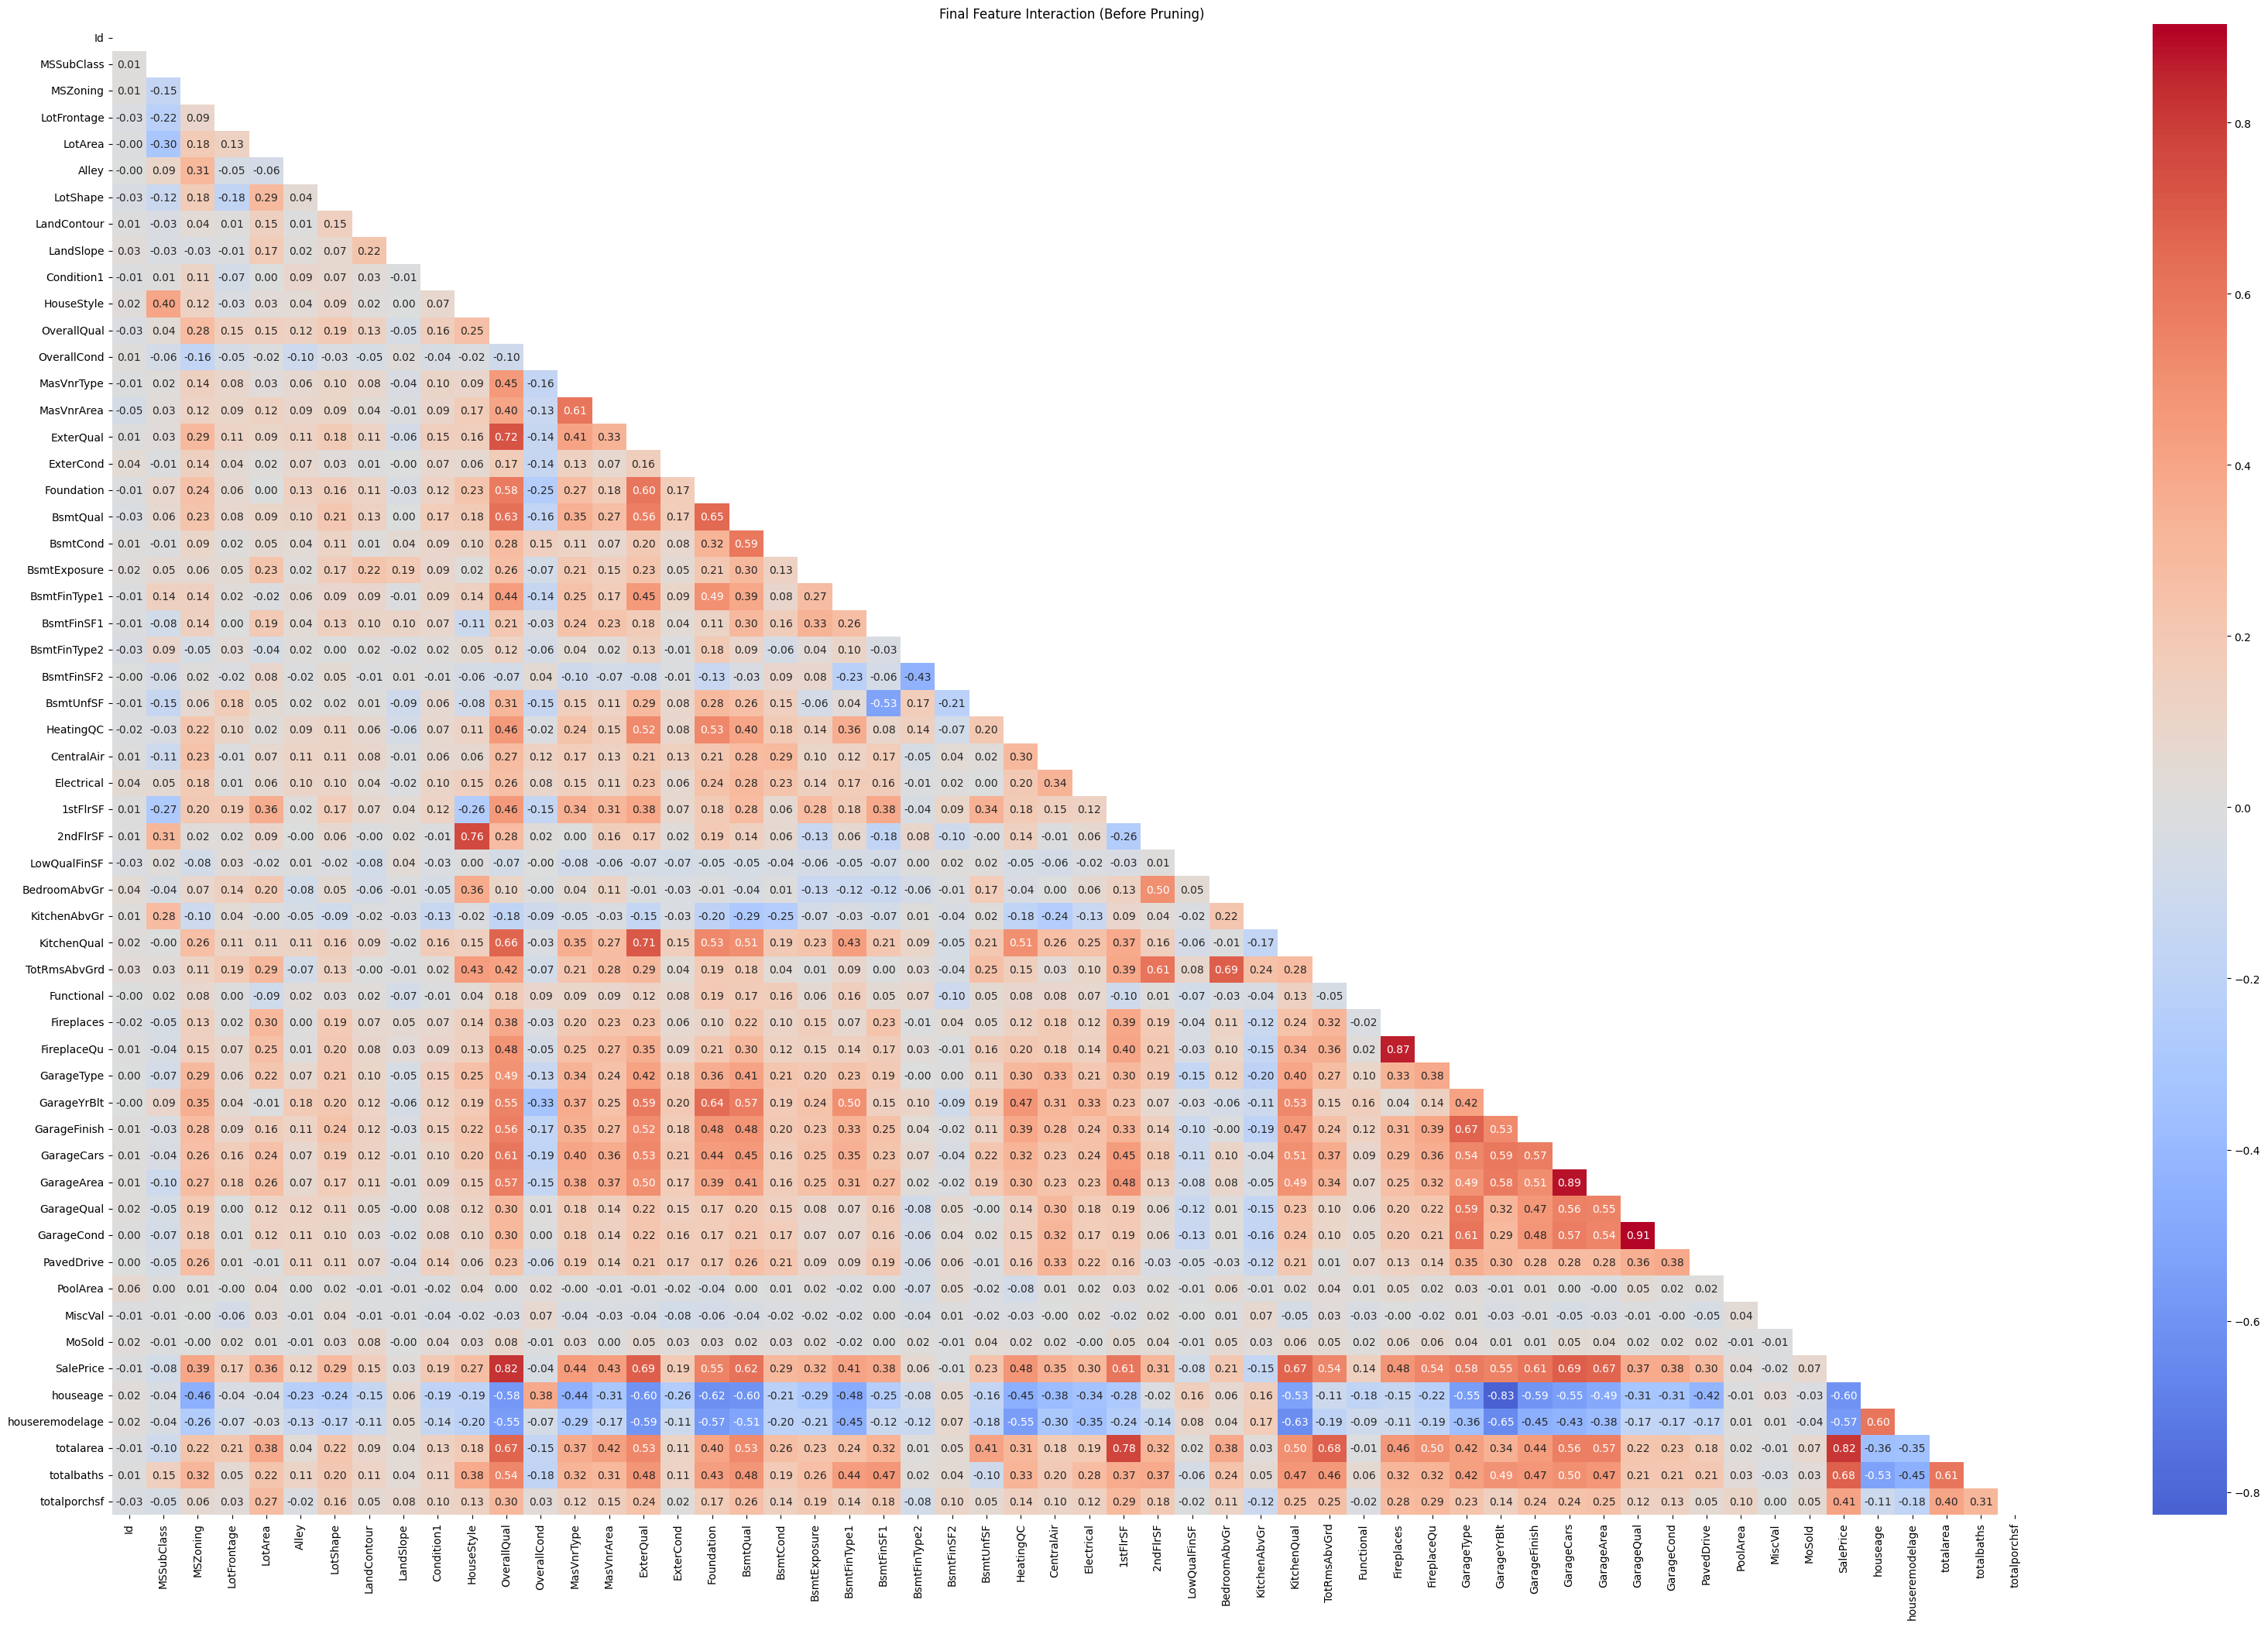

In [15]:
correlation_matrix = train_df.corr(numeric_only=True) 
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(40,25))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Final Feature Interaction (Before Pruning)")
plt.show()

In [16]:
# Feature Selection & Dimensionality Reduction

# 1. Drop features with extremely high missing values (>80% as decided in EDA)
cols_to_drop_missing = ['PoolQC', 'MiscFeature', 'Fence'] 

# 2. Drop features with near-zero variance (Dominant category > 95%)
# These features don't provide enough information for the model to learn
cols_to_drop_dominant = ['Street', 'Utilities', 'Condition2', 'Heating', 'RoofMatl']

# 3. Drop highly correlated features (Multicollinearity)
# We keep one feature from each highly correlated pair to reduce redundancy:
# - GarageCars kept (dropped GarageArea)
# - YearBuilt kept (dropped GarageYrBlt)
# - GarageQual kept (dropped GarageCond)
# - FireplaceQu kept (dropped Fireplaces)
cols_to_drop_corr = ['GarageArea', 'GarageYrBlt', 'GarageCond', 'Fireplaces', 'Id']

final_drop_list = cols_to_drop_missing + cols_to_drop_dominant + cols_to_drop_corr 

train_df.drop(columns=final_drop_list, inplace=True, errors='ignore')
test_df.drop(columns=final_drop_list, inplace=True, errors='ignore')

After feature pruning, this heatmap verifies that multicollinearity
has been reduced while preserving the strongest predictive relationships.


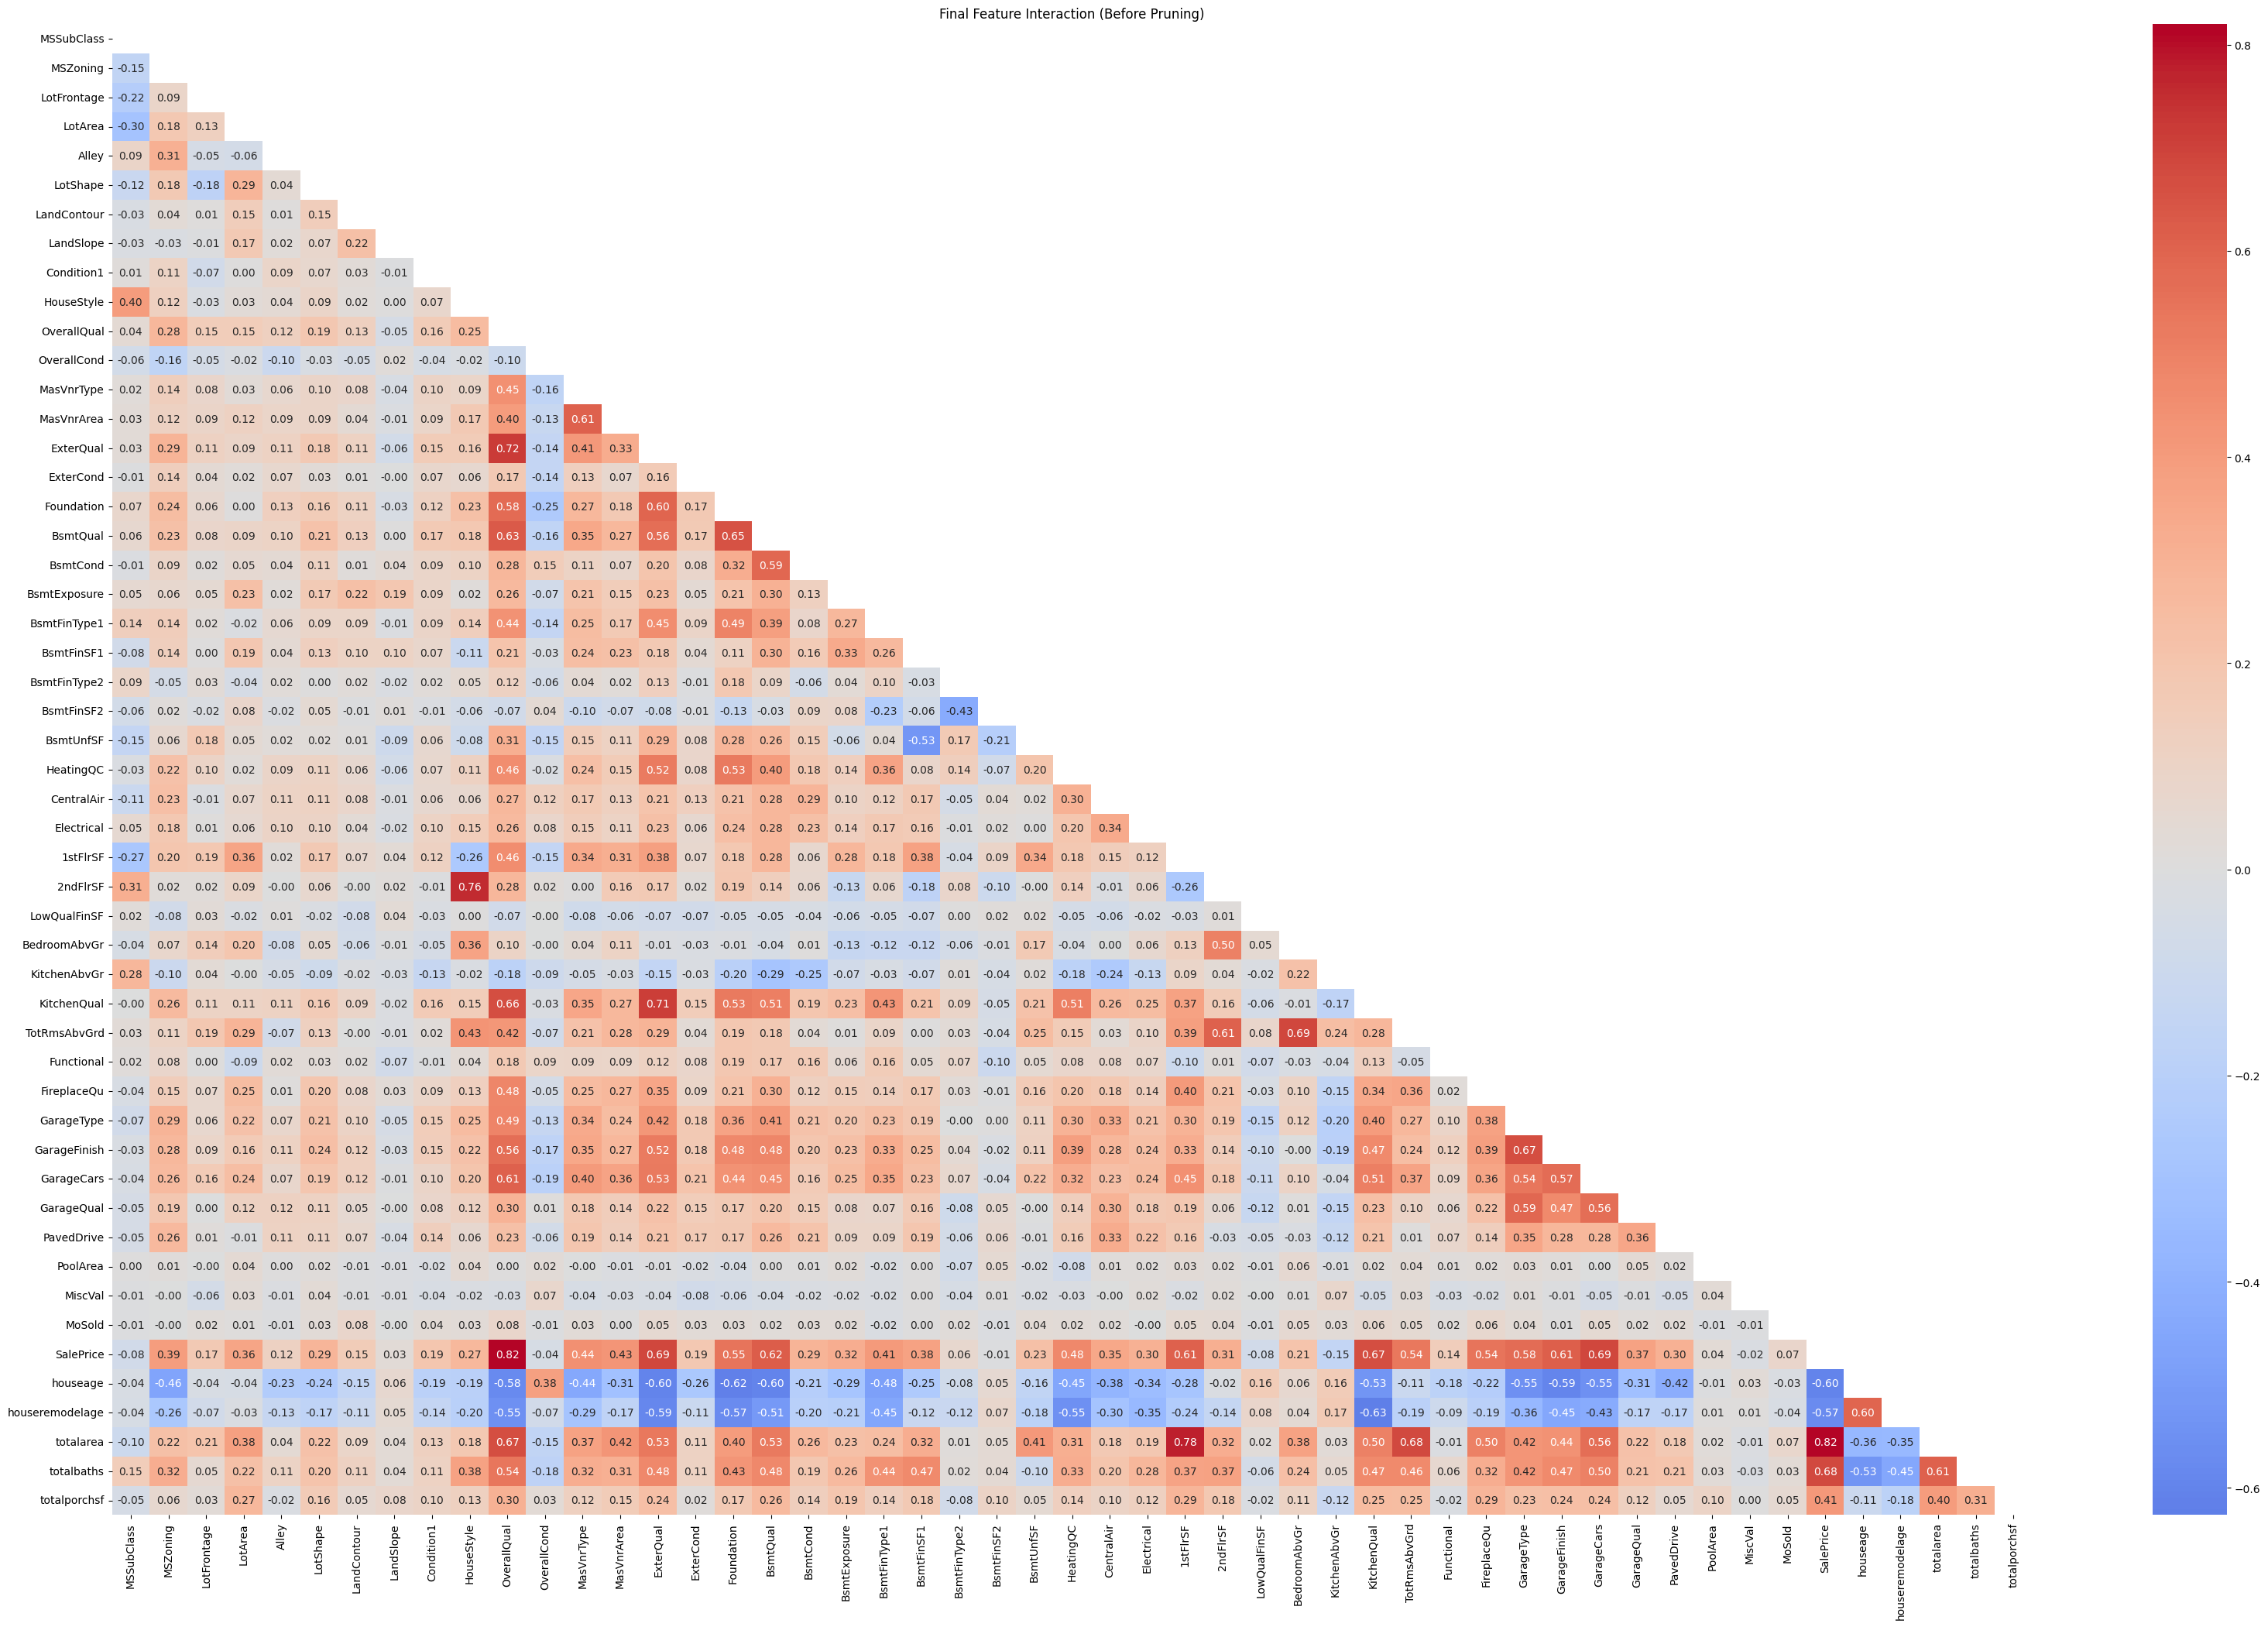

In [17]:
correlation_matrix = train_df.corr(numeric_only=True) 
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(40,25))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Final Feature Interaction (Before Pruning)")
plt.show()

### Preprocessing Pipeline

#### `Data Splitting`

In [18]:
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

#### `Automated Preprocessing Pipeline`
All preprocessing steps were consolidated into a single pipeline
to avoid data leakage and ensure reproducibility.

In [20]:
targetE_cols = ['Neighborhood', 'Exterior1st', 'Exterior2nd']
ohe_cols = ['LotConfig','RoofStyle', 'SaleCondition', 'BldgType', 'SaleType']
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

targetE_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('tergetE', ce.TargetEncoder(smoothing=10))
])

ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [21]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('targetE_p', targetE_pipeline, targetE_cols),
    ('ohe_p', ohe_pipeline, ohe_cols)
    ],
    remainder='drop',
    n_jobs=-1)

In [22]:
X_train.select_dtypes(include=['object']).columns


Index(['LotConfig', 'Neighborhood', 'BldgType', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'SaleType', 'SaleCondition'],
      dtype='object')

In [23]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [24]:
X_train_preprocessed = pipeline.fit_transform(X_train, y_train)
X_test_preprocessed = pipeline.transform(X_test)

### Model Training & Evaluation
Hyperparameters were optimized using Optuna with 5-Fold CV.


In [25]:
lr = LinearRegression()
lr.fit(X_train_preprocessed, y_train)

y_pred_lr = lr.predict(X_test_preprocessed)

np.sqrt(mean_squared_error(y_test, y_pred_lr))

np.float64(0.1127676416206501)

In [26]:
# models with best params from optuna.
final_ridge = Ridge(alpha=11.015056790269638, solver='cholesky', random_state=42)

final_xgb = XGBRegressor(n_estimators=2344,
                         max_depth=3,
                         learning_rate=0.010995780706257275,
                         subsample=0.5032771700290668,
                         colsample_bytree=0.6532582074342806,
                         reg_alpha=0.39975402381338976,
                         reg_lambda=2.062558657922061,
                         min_child_weight=3,
                         random_state=42, 
                         verbosity=0)

final_gbr = GradientBoostingRegressor(n_estimators=2899, 
                                      max_depth=4, 
                                      learning_rate=0.0037873524294740543, 
                                      subsample=0.3401227521784775, 
                                      max_features=0.25868425566686204,
                                      min_samples_leaf=5,
                                      min_samples_split=17,
                                      random_state=42)

final_lgbm = lgb.LGBMRegressor(n_estimators=2059, 
                               learning_rate=0.005627035068472362,
                               num_leaves=26,
                               min_child_samples=12,
                               reg_alpha=0.11889380370039195,
                               reg_lambda=0.029531782415710237,
                               colsample_bytree=0.3672036876746482,
                               subsample=0.6004305308267477,
                               subsample_freq=2,
                               random_state=42, 
                               verbosity=-1)

final_cat = CatBoostRegressor(iterations=2003,
                          depth=3,
                          learning_rate=0.02093119419796248,
                          random_strength=9.49832943872932,
                          bagging_temperature=0.15705109755836116,
                          border_count=98,
                          l2_leaf_reg=3.9259923205055367,
                          random_state=42, 
                          verbose=0)

#### `Ensemble Strategy`
A weighted ensemble was built to balance:
- Stability of linear models
- Non-linear learning of tree-based models

Weights were assigned based on cross-validation performance.

In [27]:
estimators = [
    ('ridge', final_ridge),
    ('gbr', final_gbr),
    ('cat', final_cat),
    ('xgb', final_xgb),
    ('lgb', final_lgbm)
]

In [28]:
vr = VotingRegressor(estimators=estimators, weights=[0.40, 0.18, 0.22, 0.10, 0.10])
vr.fit(X_train_preprocessed, y_train)

,estimators,"[('ridge', ...), ('gbr', ...), ...]"
,weights,"[0.4, 0.18, ...]"
,n_jobs,None
,verbose,False
,alpha,11.015056790269638
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'cholesky'
,positive,False


In [29]:
y_pred_vr = vr.predict(X_test_preprocessed)
root_mean_squared_error(y_test, y_pred_vr)

c:\Users\DELL\anaconda3\envs\jupyter_environment\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



0.11075309219825304

#### `Final Training & Submission`

In [30]:
X_train_final = pipeline.fit_transform(X, y)

In [31]:
vr_final = VotingRegressor(estimators=estimators, weights=[0.40, 0.18, 0.22, 0.10, 0.10])
vr_final.fit(X_train_final, y)

,estimators,"[('ridge', ...), ('gbr', ...), ...]"
,weights,"[0.4, 0.18, ...]"
,n_jobs,None
,verbose,False
,alpha,11.015056790269638
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'cholesky'
,positive,False


In [32]:
df_test_preprocess = pipeline.transform(test_df)
final_blend_comp = vr_final.predict(df_test_preprocess)

c:\Users\DELL\anaconda3\envs\jupyter_environment\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



In [33]:
final_blend_comp = np.clip(final_blend_comp, 10.5, 14.5)
y_final_prices = np.expm1(final_blend_comp)
test_df_original = pd.read_csv(test_path)
df_out = pd.DataFrame()

df_out['Id'] = test_df_original['Id']
df_out['SalePrice'] = y_final_prices

df_out.to_csv('submission.csv', index=False)

### Key Takeaways

- Data understanding had a larger impact than model complexity.
- Encoding decisions significantly affected model stability.
- Simpler models improved ensemble robustness.
